# Gene expression part 02
### Credit: Griffin Chure & Manuel Razo-Mejia

In part two of the project, we'll extract some information about the objects in our image. For this script, we only need to load the image from and can ignore the other details of part 1. Load up the phase image and display it. 

In [1]:
% Ignore this line, I am just setting my working directory to where the data is
cd('~/Documents/PhD/RPGroup-PBoC_github/mbl_pboc_2016/src/data/lacI_example/')

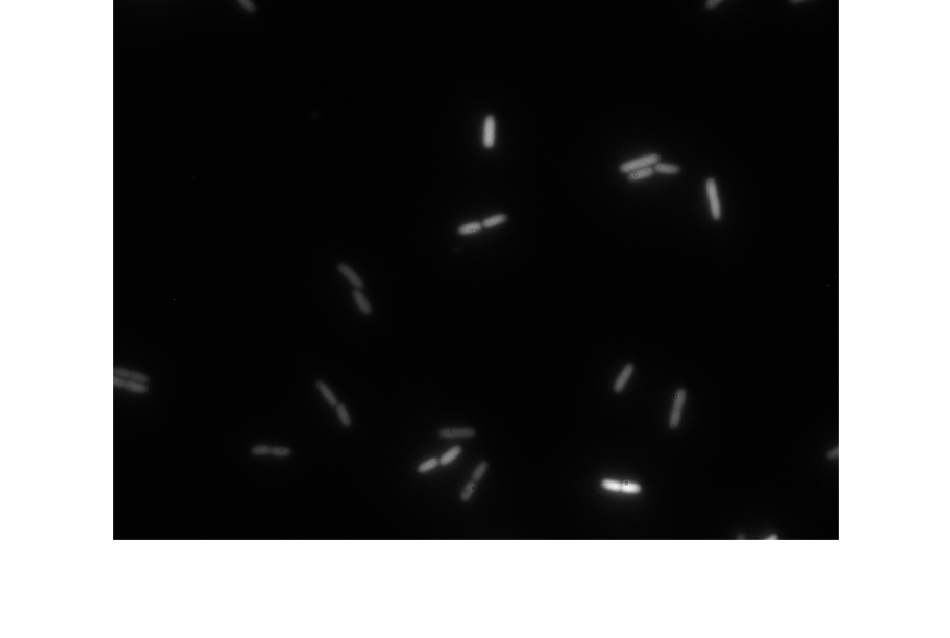

In [3]:
% Read the phase contrast image
imCherry = imread('img_000000000_TRITC_bin2_000.tif');

% Display the image
imshow(imCherry, []); % Don't forget to rescale the image!

As we saw in part I of the project, the bacteria are bright on a dark background. By looking at the histogram, we can get an idea for what those values are. However, the absolute pixel values are dependent on the illumination of each individual image. These absolute pixel values will change from day-to-day and image-to-image. What is more or less constant, however, is that the ratio of bacterial pixel values to the background. We can rescale all of the pixel values from 0 to 1 (called  normalization) with a simple matlab command called `mat2gray` which converts any image into a grayscale image.

In [11]:
% Normalizing the image to floats between 0 and 1
imNorm = mat2gray(imCherry);

Now we can see that the pixel values range only between 0 and 1! Great! Now we can look at the image without having to rescale the values in our viewing window. 

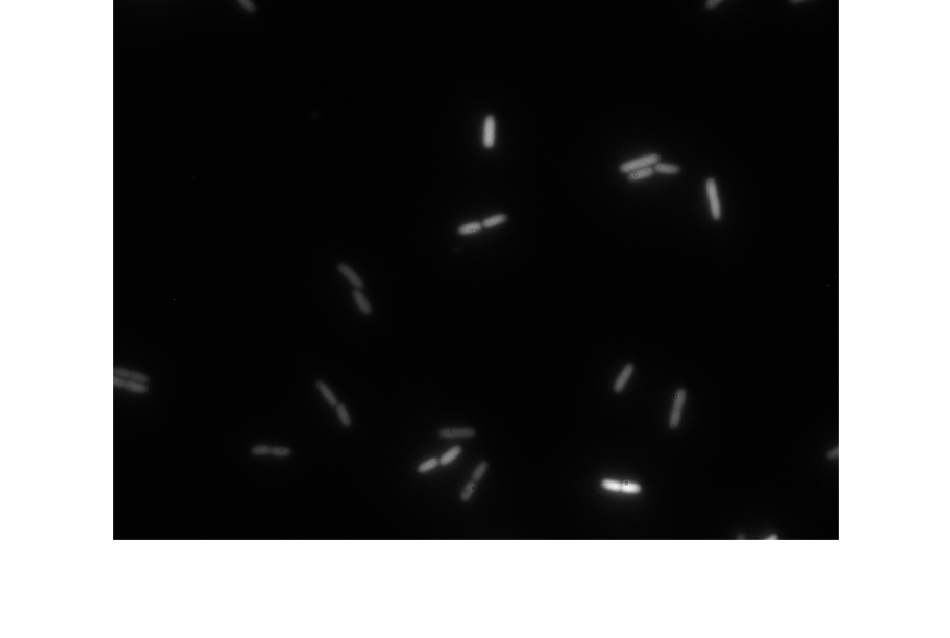

In [12]:
imshow(imNorm);

If we look at the image, there is some very obvious un-even illumination. The upper left-hand image corner of the image is noticeably darker than the bottom right-hand corner. If we are applying a simple threshold to the image, this will be a problem as background pixels will be selected as well. There are many different kinds of image filters we can use to remove computationally this type of uneven illumination. 

Today, we'll try out a gaussian filter. In this filter, each pixel of the image is given a value that is the weighted average of all the pixels nearby within a given radius. The objective of this filtering is to get the "general background" of the image ignoring the small features such as the bacteria and the other little speckles in the image. We will therefore use a radius that is larger than the size of a typical bacteria.

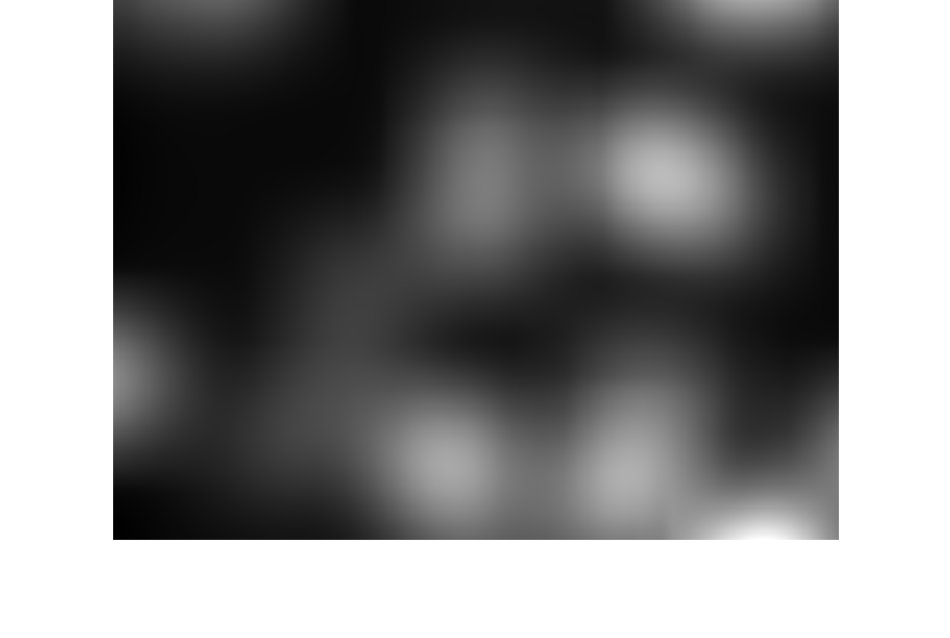

In [27]:
% Define the radius of the gaussian blur
radius = 50;

% Apply the Gaussian blur to the image
imBlur = imgaussfilt(imNorm, radius);

% Display the blur
imshow(imBlur, []);

We can see that by applying this Gaussian blur we got a weird pattern of illumination.

Since the images are just matrices, we can literally substract one image from the other to see how the illumination improves.

To have a visual comparison we will use matlab's `subplot` function that allows us to print multiple plots together.

In [15]:
%plot -s 600,200

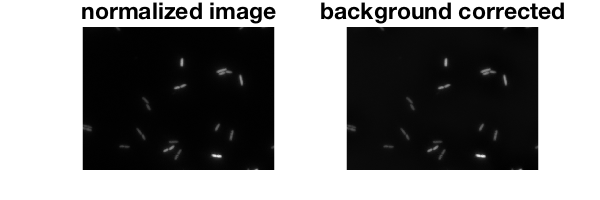

In [28]:
% Substract background
imBgSubstract = imNorm - imBlur;

% Show both images for comparison
fig = figure; % initialize a figure
% Generate the first subplot subplot with the noralized image
subplot(1, 2, 1);
imshow(imNorm);
title('normalized image')
% Generate the second subplot with the image with the extracted background
subplot(1, 2, 2);
imshow(imBgSubstract, []);
title('background corrected')

The difference between images is quite notorious!
But note that I had to rescale the background corrected image. That is because some of the pixels had negative values. We can use again the `mat2gray` function over this image to get a normalized image again.

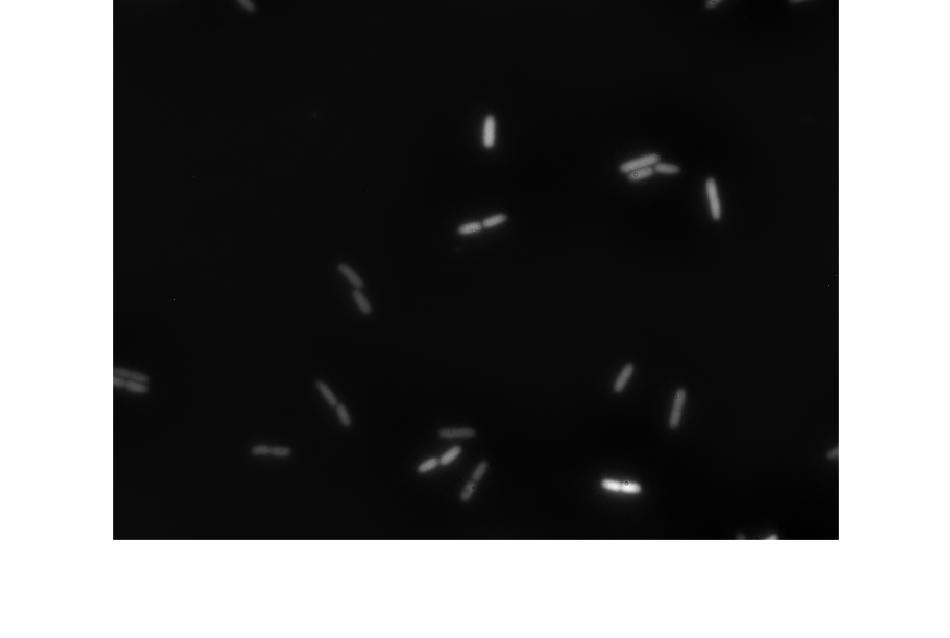

In [29]:
imBgNorm = mat2gray(imBgSubstract);
imshow(imBgNorm)

Now that the uneven illumination is gone, let's try choosing a threshold for the bacteria using our old friend `imhist`.

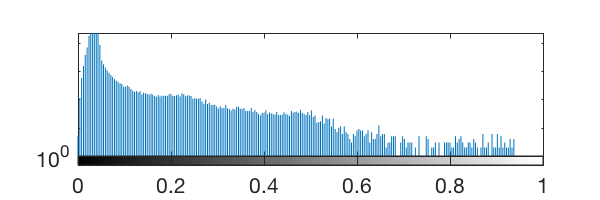

In [30]:
% Generate the pixel value histogram
imhist(imBgNorm);
set(gca, 'Yscale', 'log');

The peak is not as clear as it was for the original image we saw in part 01. But still we can see a little deep around 0.3. We can always try different threshold values and see which one works better. But for now let's play with this value.

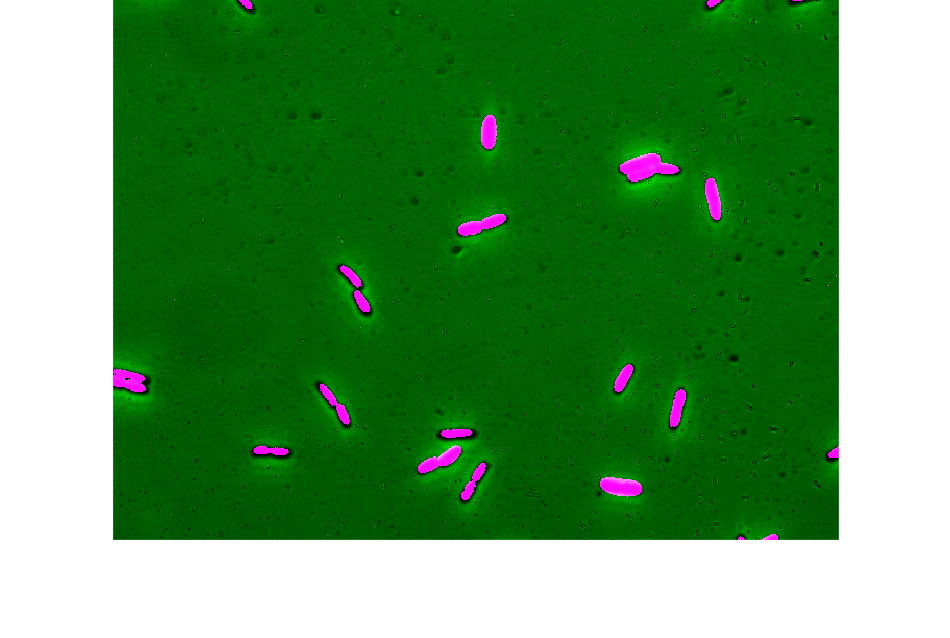

In [31]:
thresh = 0.18;
imThresh = imBgNorm > thresh;
imshowpair(imPhase, imThresh);

That looks pretty decent! But there is still some residual junk. In part 1, we discussed ways that we could better classify what a bacterium is. However, the image we have right now only shows what pixels in the image correspond to bacteria. 

One idea to filter this junk would be to keep objects of only certain area. But before we can start asking what what the area is of each cell, we must first be able to isolate each one. We can do this with a simple but very powerful matlab command called `bwlabel` which will identify each individual object in an image. 

What `bwlabel` does is that it looks on a binary image, i.e. composed only of zeros and ones, clustered ones and assigns them with a label. This is easier to understand when we see the output of the function.

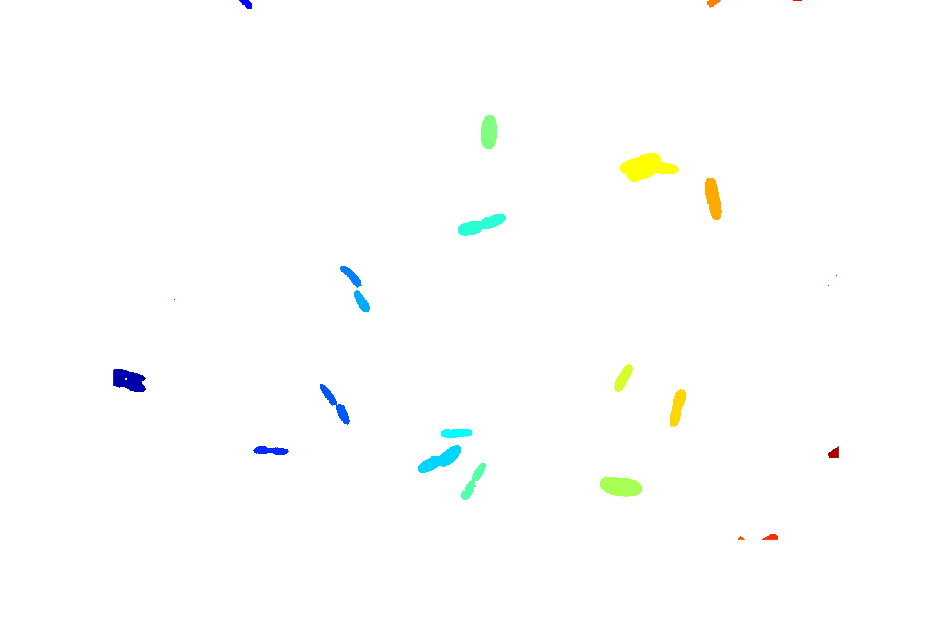

In [26]:
% Generate a labeled image with bw label
imLabeled = bwlabel(imThresh);

% Print the image, but instead of using a regular black and withe color map
% we will use the label2rgb function to color each cluster of ones with a
% different color
imshow(label2rgb(imLabeled))

So with this plotting style we are getting all the different clusters of ones with different colors. This image is what we call a "segmentation mask". Each of these clusters is labeled with either all ones, or all twos and so one depending on how many objects the `bwlabel` image found.

So to find the total number of objects we just need to find the maximum value in this matrix.

In [49]:
numObjects = max(imLabeled(:))

numObjects =

    15


We can extract each of these objects individually by using matlab boolean operators. But first let me introduce to you the `==` operator. If I ask matlab

`a == 15`,

matlab interprets this as asking if the variable named `a` has **exactly** a value of 15. If `a` indeed has indeed this value matlab returns `1`, i.e. **True**. If `a` is not equal to 15 then matlab returns a `0`, i.e. **False**. Let's look at this.

In [50]:
a = 17; % Define the variable to be 17
a == 15 % Ask if the value of the variable is exactly 15

ans =

  logical

   0


So in this case matlab told me that my variable `a` is **not equal** to 15.

Now if we apply this to the entire image asking for example

`imLabeled == 3`,

matlab goes through every entry in the matrix and asks the question: is this entry exactly equal to 3? Therefore all the pixels that form part of object number 3 are turned into ones and the rest into zero. Let's look at this in action.

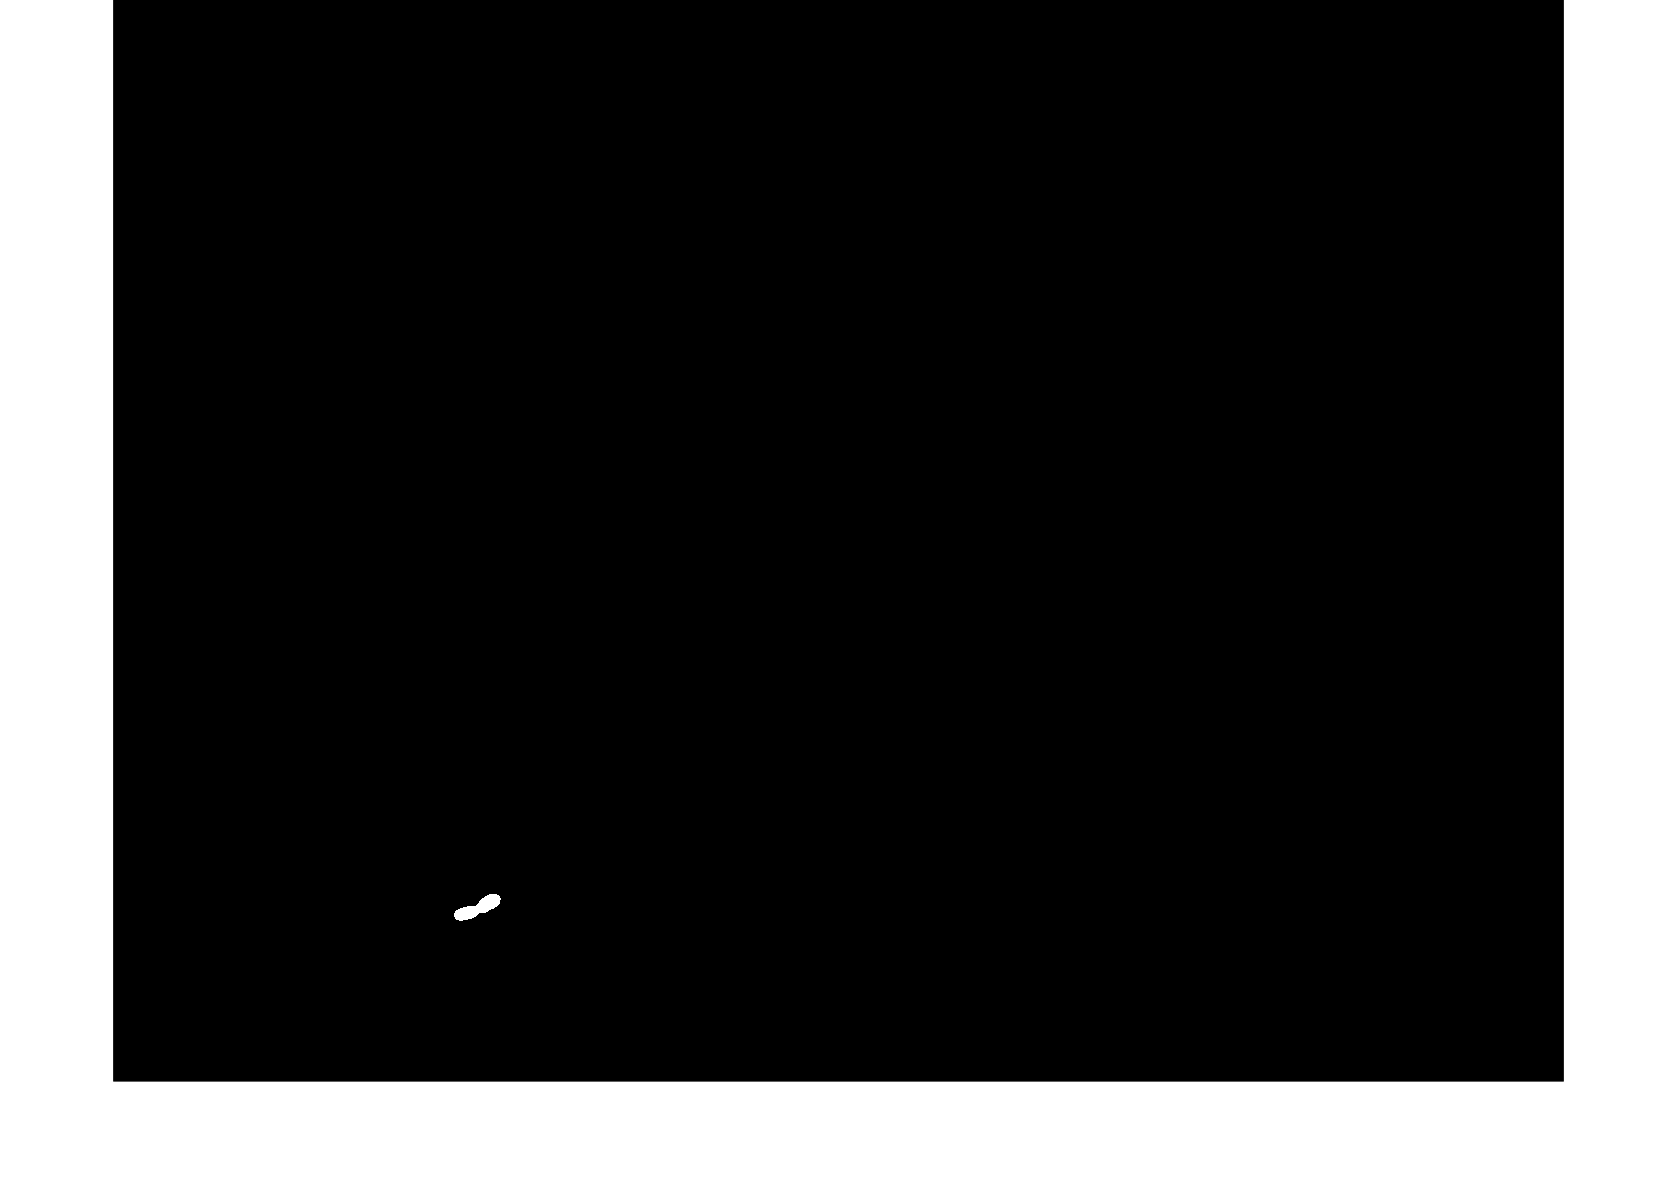

In [56]:
imLabeled_3 = imLabeled == 3;
imshow(imLabeled_3);

So only the object labeled with number 3 is printed in this binary image. This property will become very handy in the future.

Now that we have a way to get individual objects let's go back to our original question. We were interested in obtaining the area (i.e. the total number of pixels) that form each of these objects.

If in this binary image the object is formed by ones and the background is zeros, we can in principle obtain the area of the object by summing all of the pixels in this image. For this we can use the function `sum` combined with our elegant trick for converting a 2D matrix into a 1D array.

In [59]:
% Sum all the pixels in the binary image of object 3 in order to obtain the area
area_3 = sum(imLabeled_3(:))

area_3 =

   542


Rather than doing this by hand, we can use the incredibly powerful `regionprops` command to extract all sorts of information for us. Make sure you check [the documentation](http://www.mathworks.com/help/images/ref/regionprops.html) for `regionprops` since this function does many more things other than obtaining areas.

In simple terms `regionprops` goes through every object in a labeled image and extracts whichever property we ask for. In this case we are interested in obtaining the area of each of these objects.

In [62]:
% Extract the areas of all the objects in the imLabeled image
prop = regionprops(imLabeled, 'Area');

Having extracted the area for each of these objects we can dump all of these values into a single array by doing

In [63]:
areas = [prop.Area];

Now finally for this session let's look at a histogram of the areas.

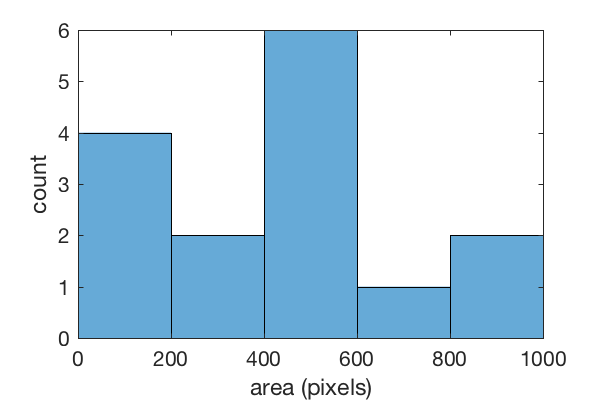

In [72]:
% Plot a histogram of the areas
histogram(areas, 5)

% As any decent plot let's label the axis
xlabel('area (pixels)')
ylabel('count')

This is one of the cases where looking at a histogram is hard because the number of bins affects a lot the visualization of the distribution. That is one of the many cases where the [empirical cumulative distribution function](https://en.wikipedia.org/wiki/Empirical_distribution_function) or ECDF is better than a histogram. In matlab we can use the `cdfplot` command.

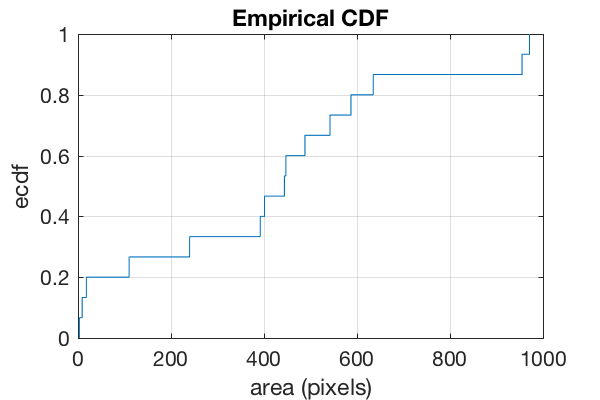

In [76]:
cdfplot(areas);
xlabel('area (pixels)')
ylabel('ecdf')